In [35]:
import models
import numpy as np
import jax.numpy as jnp
import objax
import jax
import data
import util
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [83]:
def cm_plot(cm):
    labels = ['Annual Crop', 'Forest', 'Herbaceous Vegetation', 'Highway',
              'Industrial Buildings', 'Pasture', 'Permanent Crop',
              'Residential Buildings', 'River', 'Sea & Lake']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)    
    return disp.plot(include_values=True,
                     cmap='viridis', ax=None, xticks_rotation='vertical',
                     values_format=None)

def save_plot(y_true, y_pred, title, fname):
    plot = cm_plot(confusion_matrix(y_true, y_pred))
    plot.figure_.suptitle(title)
    plot.figure_.savefig(fname, bbox_inches='tight')

## run test data and check logits for a sample

In [7]:
# best siso model
net = models.NonEnsembleNet(num_classes=10,
                            max_conv_size=213,
                            dense_kernel_size=73,
                            seed=0)
objax.io.load_var_collection('saved_models/12_full_rerun/20200915_211949/ckpt/0000000026.npz', net.vars())

In [62]:
# best simo model
net = models.EnsembleNet(num_models=4,
                         num_classes=10,
                         max_conv_size=127,
                         dense_kernel_size=112,
                         seed=0)
objax.io.load_var_collection('saved_models/12_full_rerun/20200915_230349/ckpt/0000000029.npz', net.vars())

In [85]:
# best mimo model
net = models.EnsembleNet(num_models=4,
                         num_classes=10,
                         max_conv_size=137,
                         dense_kernel_size=115,
                         seed=0)
objax.io.load_var_collection('saved_models/12_full_rerun/20200916_024542/ckpt/0000000039.npz', net.vars())

In [91]:
# best simo_ld model
net = models.EnsembleNet(num_models=4,
                         num_classes=10,
                         max_conv_size=256,
                         dense_kernel_size=38,
                         seed=0)
objax.io.load_var_collection('saved_models/12_full_rerun/20200916_012048/ckpt/0000000027.npz', net.vars())

overall validation / test accuracy

In [92]:
print("validation %0.3f" % util.accuracy(net, data.validation_dataset(batch_size=100)))
print("test %0.3f" % util.accuracy(net, data.test_dataset(batch_size=100)))

validation 0.914
test 0.911


confusion matrix

In [93]:
logits = []
y_true = []
for imgs, labels in data.test_dataset(batch_size=100): 
    logits.append(net.logits(imgs, single_result=False, logits_dropout=False))
    y_true.extend(labels)
logits = jnp.stack(logits)              # (27, M, 100, 10)
logits = logits.transpose((1,0,2,3))    # (M, 27, 100, 10)
logits = logits.reshape((4, 2700, 10))  # (M, 2700, 10)
print(logits.shape) #.reshape((-1, 10))

(4, 2700, 10)


overall ensemble predictions and accuracy

In [94]:
y_pred = jnp.argmax(logits.sum(axis=0), axis=-1)
y_pred.shape

(2700,)

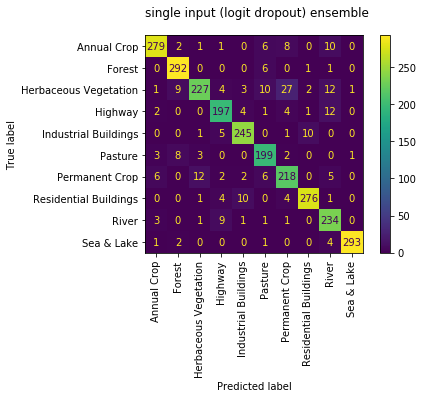

In [95]:
save_plot(y_true, y_pred, "single input (logit dropout) ensemble", "cm.simo_ld.ensemble.png")

per model predictions and accuracy

model 0
accuracy 0.764
model 1
accuracy 0.827
model 2
accuracy 0.772
model 3
accuracy 0.710


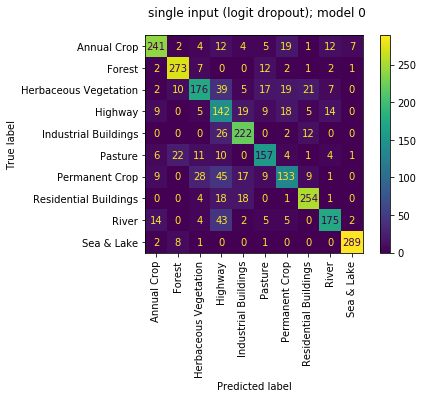

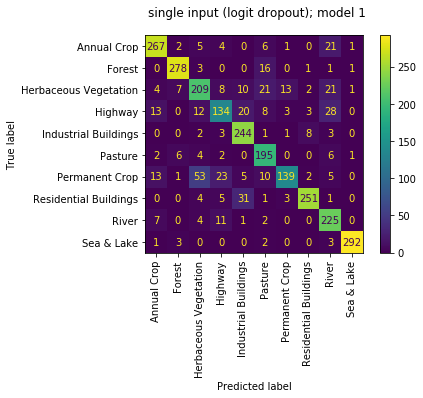

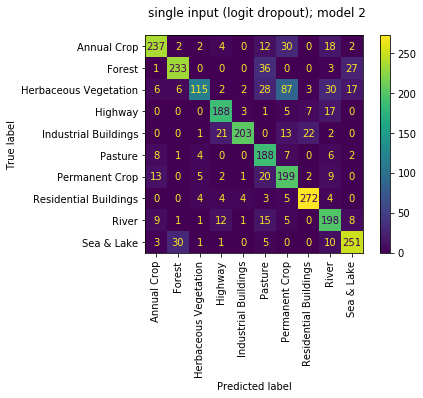

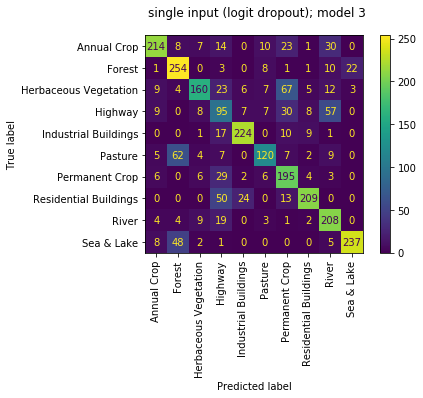

In [96]:
for m in range(4):
    print("model", m)
    y_pred = jnp.argmax(logits[m], axis=-1)        
    num_correct = np.equal(y_pred, y_true).sum()
    num_total = len(y_true)
    print("accuracy %0.3f" % float(num_correct / num_total))
    save_plot(y_true, y_pred, 
              "single input (logit dropout); model %d" % m,
              "cm.simo_ld.model_%d.png" % m)